<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/utilities/mask2bbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/pytorch/hub/raw/master/images/deeplab1.png

--2023-02-10 06:40:41--  https://github.com/pytorch/hub/raw/master/images/deeplab1.png
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pytorch/hub/master/images/deeplab1.png [following]
--2023-02-10 06:40:41--  https://raw.githubusercontent.com/pytorch/hub/master/images/deeplab1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2487681 (2.4M) [image/png]
Saving to: ‘deeplab1.png’

deeplab1.png        100%[===================>]   2.37M  --.-KB/s    in 0.02s   

2023-02-10 06:40:42 (103 MB/s) - ‘deeplab1.png’ saved [2487681/2487681]



In [2]:
import numpy as np
import torch
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

filename = "deeplab1.png"

input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

In [11]:
print(np.unique(output_predictions.byte().cpu().numpy()))

[ 0 15 17]


In [12]:
mask = output_predictions.byte().cpu().numpy()

In [27]:
def get_assigned_mask(id, mask):
  mask_ = np.zeros_like(mask)
  for i in range(mask_.shape[1]):
    for j in range(mask_.shape[0]):
      if mask[j, i] == id:
        mask_[j, i] = 1
  return mask_

def calc_bbox(assigned_mask):
  rows = np.any(assigned_mask, axis=1)
  cols = np.any(assigned_mask, axis=0)
  # print(rows)
  y_min, y_max = np.where(rows)[0][[0, -1]]
  x_min, x_max = np.where(cols)[0][[0, -1]]

  return y_min, y_max, x_min, x_max

In [24]:
mask_15 = get_assigned_mask(15, mask)
mask_17 = get_assigned_mask(17, mask)

In [29]:
y_min, y_max, x_min, x_max = calc_bbox(mask_15)

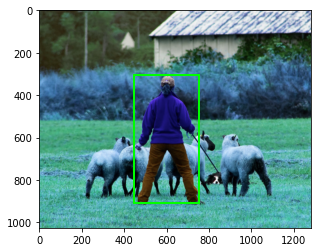

In [30]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2

im = cv2.imread("deeplab1.png")

rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2,
                                 edgecolor=(0, 1, 0, 1),
                                 facecolor='none')

plt.imshow(im)
ax = plt.gca()
ax.add_patch(rect)

plt.show()